In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt

import torch

from IPython.display import clear_output
from nnsight import LanguageModel

In [ ]:
# Set hf token
os.environ['HF_TOKEN'] = ''  # Replace with your actual Hugging Face token

In [20]:
clear_output()


LANG = "turkish"  # Language of the idioms
TASK = "dodiom"

NUM_SAMPLES_TRAIN = 5000  # Number of samples to use for training
NUM_SAMPLES_TEST = 0  # Number of samples to use for testing, 0 means use all available test data
# MODEL_PATH = "meta-llama/Llama-3.1-8B-Instruct"
MODEL_PATH = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL_PATH = "models/llama_8b_en"

OUTPUT_DIR = "outputs"
RES_DIR = "results"

LAYER_WISE_PROBING = True  # set to False to use single-layer span vector

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
print("Using CUDA device:", os.environ["CUDA_VISIBLE_DEVICES"])

output_dir = os.path.join(OUTPUT_DIR, LANG, TASK)
model_name = MODEL_PATH.split("/")[-1]


num_samples_train_str = "all" if NUM_SAMPLES_TRAIN <= 0 else str(NUM_SAMPLES_TRAIN)
num_samples_test_str = "all" if NUM_SAMPLES_TEST <= 0 else str(NUM_SAMPLES_TEST)

meta_train_file = os.path.join(output_dir, f"all_hidden_train_{num_samples_train_str}_{model_name}.jsonl")
vectors_train_file = os.path.join(output_dir, f"all_hidden_train_{num_samples_train_str}_{model_name}_vectors.pt")

meta_test_file = os.path.join(output_dir, f"all_hidden_test_{num_samples_test_str}_{model_name}.jsonl")
vectors_test_file = os.path.join(output_dir, f"all_hidden_test_{num_samples_test_str}_{model_name}_vectors.pt")

# meta_test_file = None
# vectors_test_file = None

layer_wise = "all_hidden" if LAYER_WISE_PROBING else "last_hidden"
RES_DIR = os.path.join(RES_DIR, LANG, TASK, f"{layer_wise}_{model_name}_{num_samples_train_str}_samples")
log_file = os.path.join(RES_DIR, "log.txt")
# Check if the output directory exists
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

for file_name in [meta_train_file, vectors_train_file]:
    # Check if the file exists
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"Required file {file_name} does not exist. Please run the data preparation step first.")

if meta_test_file and not os.path.exists(meta_test_file):
    raise FileNotFoundError(f"Required file {meta_test_file} does not exist. Please run the data preparation step first.")
if vectors_test_file and not os.path.exists(vectors_test_file):
    raise FileNotFoundError(f"Required file {vectors_test_file} does not exist. Please run the data preparation step first.")
if meta_test_file is None and vectors_test_file is None:
    print("No test data provided. Skipping test data loading.")

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    encoding="utf-8",
    # Log to a file
    handlers=[
        logging.FileHandler(log_file, mode='w', encoding='utf-8'),
        logging.StreamHandler(sys.stdout)
    ]
    
)
logger = logging.getLogger(__name__)

# Log
logger.info(f"Results directory: {RES_DIR}")
logger.info(f"Log file: {log_file}")

# Read the output file json
try:
    logger.info(f"Reading training data from {meta_train_file}...")
    train = pd.read_json(meta_train_file, lines=True)
    logger.info(f"Training data shape: {train.shape}")
    logger.info(f"Reading vectors from {vectors_train_file}...")
    vectors_train = torch.load(vectors_train_file)
    logger.info(f"Vectors shape: {vectors_train.shape}")
    if len(vectors_train) != len(train):
        raise ValueError(f"Vectors length {len(vectors_train)} does not match data length {len(train)}.")
    # train['mean_vector'] = list(vectors_train)
    logger.info(f"Successfully read {len(train)} entries from {meta_train_file}.")
except ValueError as e:
    logger.info(f"Error reading JSON file: {e}")
    sys.exit(1)

if meta_test_file and vectors_test_file:
    try:
        test = pd.read_json(meta_test_file, lines=True)
        # Read vectors if they exist
        vectors_test = torch.load(vectors_test_file)
        if len(vectors_test) != len(test):
            raise ValueError(f"Vectors length {len(vectors_test)} does not match data length {len(test)}.")
        # test['mean_vector'] = list(vectors_test)
        logger.info(f"Successfully read {len(test)} entries from {meta_test_file}.")
    except ValueError as e:
        logger.info(f"Error reading JSON file: {e}")
        sys.exit(1)
else:
    vectors_test = None
    test = None

# Log the mean_vector shape
if vectors_test is not None:
    logger.info(f"Mean vector test shape: {vectors_test.shape}")


# Debug, use a small subset
logger.info(f"Train size before filtering: {len(train)}")
#train = train.head(500)
#vectors_train = vectors_train[:500]
logger.info(f"Train size after filtering:{len(train)}")

if test is not None:
    logger.info(f"Test size before filtering: {len(test)}")
    # test = test.head(20)
    # vectors_test = vectors_test[:20]
    logger.info(f"Test size after filtering: {len(test)}")

# Number of idiomatic vs non-idiomatic
idiomatic_count = train['idiomatic'].value_counts()
logger.info(f"Idiomatic count in Train:\n{idiomatic_count}")

Using CUDA device: 3
07/26/2025 12:21:16 - INFO - __main__ - Results directory: results/turkish/dodiom/all_hidden_Llama-3.2-3B-Instruct_5000_samples
07/26/2025 12:21:16 - INFO - __main__ - Log file: results/turkish/dodiom/all_hidden_Llama-3.2-3B-Instruct_5000_samples/log.txt
07/26/2025 12:21:16 - INFO - __main__ - Reading training data from outputs/turkish/dodiom/all_hidden_train_5000_Llama-3.2-3B-Instruct.jsonl...


07/26/2025 12:21:16 - INFO - __main__ - Training data shape: (5000, 7)
07/26/2025 12:21:16 - INFO - __main__ - Reading vectors from outputs/turkish/dodiom/all_hidden_train_5000_Llama-3.2-3B-Instruct_vectors.pt...
07/26/2025 12:21:18 - INFO - __main__ - Vectors shape: torch.Size([5000, 29, 3072])
07/26/2025 12:21:18 - INFO - __main__ - Successfully read 5000 entries from outputs/turkish/dodiom/all_hidden_train_5000_Llama-3.2-3B-Instruct.jsonl.
07/26/2025 12:21:19 - INFO - __main__ - Successfully read 4278 entries from outputs/turkish/dodiom/all_hidden_test_all_Llama-3.2-3B-Instruct.jsonl.
07/26/2025 12:21:19 - INFO - __main__ - Mean vector test shape: torch.Size([4278, 29, 3072])
07/26/2025 12:21:19 - INFO - __main__ - Train size before filtering: 5000
07/26/2025 12:21:19 - INFO - __main__ - Train size after filtering:5000
07/26/2025 12:21:19 - INFO - __main__ - Test size before filtering: 4278
07/26/2025 12:21:19 - INFO - __main__ - Test size after filtering: 4278
07/26/2025 12:21:19 -

In [21]:
# Print vectors shape
logger.info(f"Vectors train shape: {vectors_train.shape}")

07/26/2025 12:21:19 - INFO - __main__ - Vectors train shape: torch.Size([5000, 29, 3072])


In [22]:
def get_layer_i_vector(vectors_matrix: np.ndarray, layer_index: int) -> np.ndarray:
    """
    Extract vectors from a specific layer across all samples.
    :param vectors_matrix: A 3D numpy array with shape (num_samples, num_layers, dim)
    :param layer_index: The index of the layer to extract.
    :return: 2D array of shape (num_samples, dim)
    """
    if layer_index == -1:
        # If layer_index is -1, return the last layer
        layer_index = vectors_matrix.shape[1] - 1
    assert vectors_matrix.ndim == 3, "Input must be a 3D numpy array."
    assert 0 <= layer_index < vectors_matrix.shape[1], "Layer index out of bounds."
    return vectors_matrix[:, layer_index, :]

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
logitlens = os.path.join(RES_DIR, "logitlens")
os.makedirs(logitlens, exist_ok=True)

model = LanguageModel(MODEL_PATH, device_map="auto", dispatch=True)


07/26/2025 12:21:20 - INFO - accelerate.utils.modeling - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
07/26/2025 12:21:20 - INFO - accelerate.utils.modeling - Based on the current allocation process, no modules could be assigned to the following devices due to insufficient memory:
  - 0: 1978687488 bytes required
These minimum requirements are specific to this allocation attempt and may vary. Consider increasing the available memory for these devices to at least the specified minimum, or adjusting the model config.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
from sklearn.metrics import jaccard_score

def get_token_vector(tokens: list[str], vocab: list[str]) -> list[int]:
    """Convert list of tokens to binary vector over vocab"""
    return [1 if token in tokens else 0 for token in vocab]

def compute_jaccard_sklearn(words1: list[str], words2: list[str]) -> float:
    """Compute Jaccard similarity between two token lists using sklearn"""
    vocab = list(set(words1) | set(words2))
    vec1 = get_token_vector(words1, vocab)
    vec2 = get_token_vector(words2, vocab)
    return jaccard_score(vec1, vec2)

In [26]:
words_path = os.path.join(logitlens, "logit_lens_words.json")

In [ ]:
if os.path.exists(words_path):
    logger.info(f"Loading words from {words_path}...")
    # Load the words from the file
    new_df = pd.read_json(words_path, lines=True)
else:
    logger.info(f"Processing idioms to extract words...")
    # Create a DataFrame to hold the new rows

    total_selected = 0
    new_rows = []
    unique_idioms = []

    for idiom, group in tqdm(train.groupby("idiom_base"), desc="Processing idioms"):
        fig_group = group[group["idiomatic"] == True]
        lit_group = group[group["idiomatic"] == False]
        if fig_group.empty or lit_group.empty:
            continue

        unique_idioms.append(idiom)

        # Make sure amount of idiomatic and literal groups is the same
        min_samples = min(len(fig_group), len(lit_group))
        fig_group = fig_group.sample(n=min_samples, random_state=42)
        lit_group = lit_group.sample(n=min_samples, random_state=42)
        total_selected += min_samples + min_samples
        
        # Ensure the vectors are available for both idiomatic and literal groups
        fig_vecs = np.stack([vectors_train[i, :, :] for i in fig_group.index])
        lit_vecs = np.stack([vectors_train[i, :, :] for i in lit_group.index])

        idiomatic_words = [[] for _ in range(fig_vecs.shape[1])]  # List to hold words for each layer
        literal_words = [[] for _ in range(fig_vecs.shape[1])]  # List to hold words for each layer
        for rows, vecs, idiomatic in [
            (fig_group, fig_vecs, True),
            (lit_group, lit_vecs, False),
        ]:
            
            for i in range(len(rows)):
                row = rows.iloc[i]
                probs_layers = []
                for layer_idx in range(vecs.shape[1]):
                    # Get the vector for the current layer
                    layer_vec = get_layer_i_vector(vecs, layer_idx)
                    # Ensure the vector is a tensor
                    layer_vec = torch.tensor(layer_vec, device=device).unsqueeze(0)
                    # Apply normalization and lm head as the model would
                    layer_output = model.lm_head(model.model.norm(layer_vec))
                    # Apply softmax to obtain probabilities and save the result
                    probs = torch.nn.functional.softmax(layer_output, dim=-1)
                    probs_layers.append(probs)
                
                probs = torch.cat([probs for probs in probs_layers])
                # Find the maximum probability and corresponding tokens
                _, topk_tokens = probs.topk(k=5, dim=-1)  # Get top 3 predictions per position/layer
                # flatten the topk tokens for easier processing, leave first dimension as batch size
                topk_tokens = topk_tokens.reshape(topk_tokens.shape[0], -1)  # shape: [29, 9]

                # Decode top 3 tokens per layer
                words = [
                    [model.tokenizer.decode(t.item()).encode("unicode_escape").decode() for t in layer_tokens]
                    for layer_tokens in topk_tokens
                ]   

                # Append to words list
                for layer_idx, layer_words in enumerate(words):
                    if idiomatic:
                        idiomatic_words[layer_idx].extend(layer_words)
                    else:
                        literal_words[layer_idx].extend(layer_words)
                
                # Clean memory
                del layer_vec, layer_output, probs, topk_tokens, words
                # Clean up the memory
                torch.cuda.empty_cache()
        

        # Make sets to remove duplicates
        idiomatic_words = [list(set(words)) for words in idiomatic_words]
        literal_words = [list(set(words)) for words in literal_words]

        # Add the row with words to new_rows
        new_rows.append({
            "idiom_base": idiom,
            "idiomatic_words": idiomatic_words,
            "literal_words": literal_words
        })

        # Clean up memory
        del idiomatic_words, literal_words, fig_group, lit_group, fig_vecs, lit_vecs
        # Clean up memory
        torch.cuda.empty_cache()
    # Create a DataFrame from the new rows
    new_df = pd.DataFrame(new_rows)

    with open(os.path.join(logitlens, "logit_lens_idioms.txt"), "w", encoding="utf-8") as f:
        for idiom in unique_idioms:
            f.write(f"{idiom}\n")
    # Save the new DataFrame to a json file
    new_df.to_json(words_path, orient="records", lines=True, force_ascii=False)
logger.info(f"Total selected samples: {total_selected}")
logger.info(f"Unique idioms processed: {len(unique_idioms)}")
new_df.head()

07/26/2025 12:21:23 - INFO - __main__ - Processing idioms to extract words...


Processing idioms: 100%|██████████| 36/36 [00:00<00:00, 341.54it/s]

07/26/2025 12:21:23 - INFO - __main__ - Total selected samples: 4244
07/26/2025 12:21:23 - INFO - __main__ - Unique idioms processed: 36


In [12]:
len(new_df)

192

In [13]:
# Load the saved DataFrame
df = new_df

In [14]:
df.head(3)

,idiom_base,idiomatic_words,literal_words
0,all along,"[[ Along, along, along, Along, all], [ Along...","[[ Along, along, along, Along, all, All], [..."
1,all over the place,"[[ Over, places, place, all, All, Place, ...","[[ places, place, all, Place, over], [plac..."
2,anything goes,"[[Anything, anything, going, anything, Anyt...","[[Anything, went, anything, going, anything..."


In [15]:
def show_idiomatic_vs_literal(df, idiom, layers=None):
    """
    Pretty-print idiomatic vs literal top-k token predictions per layer.
    
    Args:
        df: pandas DataFrame with columns ['idiom_base', 'idiomatic_words', 'literal_words']
        idiom: string, the idiom_base to inspect
        layers: optional list of layer indices to restrict to
    """
    row = df[df['idiom_base'] == idiom]
    if row.empty:
        print(f"No entry found for idiom '{idiom}'")
        return

    idiomatic_words = row['idiomatic_words'].values[0]
    literal_words = row['literal_words'].values[0]

    n_layers = len(idiomatic_words)
    layer_range = layers if layers is not None else range(n_layers)

    print(f"--- Comparing idiomatic vs literal predicted tokens for '{idiom}' ---\n")
    for l in layer_range:
        # Flatten each layer's list (they may be list of lists)
        idiom_tokens = set([tok for sublist in idiomatic_words[l] for tok in (sublist if isinstance(sublist, list) else [sublist])])
        literal_tokens = set([tok for sublist in literal_words[l] for tok in (sublist if isinstance(sublist, list) else [sublist])])

        print(f"Layer {l}:")
        print(f"  Idiomatic tokens ({len(idiom_tokens)}): {sorted(idiom_tokens)}")
        print(f"  Literal tokens  ({len(literal_tokens)}): {sorted(literal_tokens)}")

        inter = idiom_tokens & literal_tokens
        only_idiom = idiom_tokens - literal_tokens
        only_lit = literal_tokens - idiom_tokens

        print(f"  Intersection ({len(inter)}): {sorted(inter)}")
        print(f"  Only idiomatic ({len(only_idiom)}): {sorted(only_idiom)}")
        print(f"  Only literal  ({len(only_lit)}): {sorted(only_lit)}\n")


In [16]:
show_idiomatic_vs_literal(df, "behind closed doors")


--- Comparing idiomatic vs literal predicted tokens for 'behind closed doors' ---

Layer 0:
  Idiomatic tokens (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Literal tokens  (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Intersection (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Only idiomatic (0): []
  Only literal  (0): []

Layer 1:
  Idiomatic tokens (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Literal tokens  (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Intersection (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Only idiomatic (0): []
  Only literal  (0): []

Layer 2:
  Idiomatic tokens (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Literal tokens  (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Intersection (5): [' Behind', ' Closed', ' behind', ' closed', ' doors']
  Only idiomatic (0): []
  Only literal  (0): []

Layer 3:
  Idiomatic tokens (5): [' Behind',

In [17]:
def write_idiom_token_report(
    df,
    filepath: str,
    layers: list[int] | None = None,
    header: str = "# Idiom token‑prediction comparison report\n\n"
):
    """
    Write a side‑by‑side comparison of idiomatic vs literal top‑k tokens
    for *all* idioms in `df` to `filepath`.

    Args
    ----
    df : pandas.DataFrame
        Must contain columns ['idiom_base', 'idiomatic_words', 'literal_words'].
    filepath : str
        Destination file (e.g. 'idiom_report.txt' or 'idiom_report.md').
    layers : Iterable[int] or None
        Layer indices to include; if None, include *all* layers.
    header : str
        Optional header text to put at the top of the file.
    """
    # Ensure parent directory exists
    os.makedirs(os.path.dirname(filepath) or ".", exist_ok=True)

    with open(filepath, "w", encoding="utf‑8") as f:
        f.write(header)

        for idiom, row in df.groupby("idiom_base"):
            idiomatic_words = row.iloc[0]["idiomatic_words"]
            literal_words   = row.iloc[0]["literal_words"]

            n_layers = len(idiomatic_words)
            layer_range = layers if layers is not None else range(n_layers)

            f.write(f"## {idiom}\n\n")
            for l in layer_range:
                # Flatten each layer's (possibly nested) list
                idiom_tokens = {tok for sub in idiomatic_words[l] for tok in (sub if isinstance(sub, list) else [sub])}
                literal_tokens = {tok for sub in literal_words[l] for tok in (sub if isinstance(sub, list) else [sub])}

                inter       = idiom_tokens & literal_tokens
                only_idiom  = idiom_tokens - literal_tokens
                only_lit    = literal_tokens - idiom_tokens

                f.write(f"### Layer {l}\n")
                f.write(f"- **Idiomatic ({len(idiom_tokens)})**: {sorted(idiom_tokens)}\n")
                f.write(f"- **Literal ({len(literal_tokens)})**: {sorted(literal_tokens)}\n")
                f.write(f"- **Intersection ({len(inter)})**: {sorted(inter)}\n")
                f.write(f"- **Only Idiomatic ({len(only_idiom)})**: {sorted(only_idiom)}\n")
                f.write(f"- **Only Literal ({len(only_lit)})**: {sorted(only_lit)}\n\n")

            f.write("\n---\n\n")

    print(f"Report written → {os.path.abspath(filepath)}")

In [18]:
# Keep all layers
write_idiom_token_report(df, os.path.join(logitlens, "idiom_tokens_report.txt"))

Report written → /home/kaig/cross-lingual-idioms/probing/results/english/magpie/all_hidden_Llama-3.2-3B-Instruct_5000_samples/logitlens/idiom_tokens_report.txt


In [19]:
jaccard_scores_by_idiom = {}
for idx, row in df.iterrows():
    idiom_base = row['idiom_base']
    words_idiom = row['idiomatic_words']
    words_lit = row['literal_words']
    jaccard_per_layer = []
    for layer_idx in range(len(words_idiom)):
        idiom_words = words_idiom[layer_idx]
        lit_words = words_lit[layer_idx]
        score = compute_jaccard_sklearn(idiom_words, lit_words)
        jaccard_per_layer.append(score)
        jaccard_scores_by_idiom[idiom_base] = jaccard_per_layer


In [20]:
jaccard_scores_by_idiom
# Convert to DataFrame: rows = idioms, cols = layers
j_df = pd.DataFrame.from_dict(jaccard_scores_by_idiom, orient="index")
j_df.index.name = "idiom_base"
j_df.columns.name = "layer"

# Save the DataFrame to a CSV file
j_df.to_csv(os.path.join(logitlens, "logit_lens_jaccard.csv"))

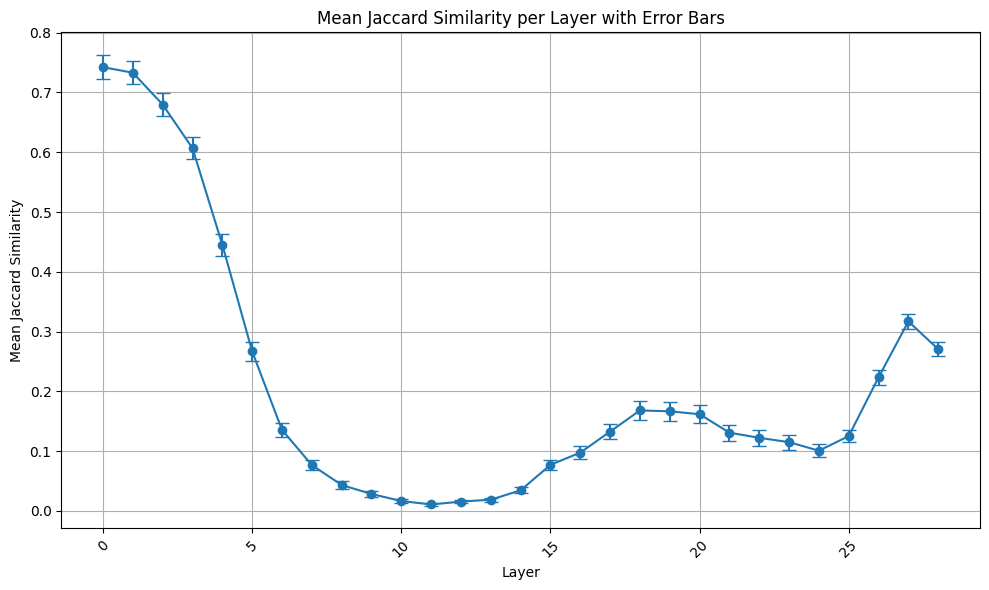

In [21]:
# per‑layer mean and standard error
mean_curve = j_df.mean(axis=0)           # shape: [n_layers]
stderr_curve = j_df.sem(axis=0)


# Save the mean and stderr curves to one CSV
jac_curves_df = pd.DataFrame({
    "mean": mean_curve,
    "stderr": stderr_curve
})
jac_curves_df.to_csv(os.path.join(logitlens, "logit_lens_jaccard_curves.csv"))
                                 
# Plotting the mean Jaccard similarity with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(mean_curve.index, mean_curve.values, yerr=stderr_curve.values, fmt='-o', capsize=5)
plt.title('Mean Jaccard Similarity per Layer with Error Bars')
plt.xlabel('Layer')
plt.ylabel('Mean Jaccard Similarity')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(logitlens, "logit_lens_jaccard_mean.png"), dpi=300)
plt.show() 